# Machine Learning

In this project I try to predict traffic speed in Ho Chi Minh City using various machine learning models. I tried to combine both regression and classification

#### Regression as the Core Model

- Use it to predict continuous speed.

- Necessary if you want to calculate travel time.

#### Classification as a Presentation Layer

- Convert predicted speed into traffic states:

0–20 km/h → Slow

20–30 km/h → Medium

more 30 km/h → Fast

- Useful for visual dashboards or alerts (e.g., “Warning: Heavy Traffic in District 1”).

=> This way, you get the accuracy of regression + the clarity of classification.

### I. Import Libraries

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import requests
import sklearn
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import json


from pytz import timezone
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix
from datetime import datetime, timedelta
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.svm import SVR , SVC
import matplotlib.pyplot as plt

%matplotlib inline 

print("Library verions:")
print("- numpy:", np.__version__)
print("- pandas:", pd.__version__)
print("- requests:", requests.__version__)
print("- sklearn:", sklearn.__version__)
print("- seaborn:", sns.__version__)

Library verions:
- numpy: 2.2.0
- pandas: 2.3.2
- requests: 2.32.5
- sklearn: 1.7.2
- seaborn: 0.13.2


### II. Data Collection & Processing

In [53]:
# Set API key (for traffic data and weather data)
TOMTOM_API_KEY = os.environ.get("TOMTOM_API_KEY")
OPENWEATHER_API_KEY = os.environ.get("OPENWEATHER_API_KEY")
# Coordinates for key locations (latitude, longitude) in HCMC
hcmc_locations = {
    "District_1": {"lat": 10.7757, "lon": 106.7009},
    "Thu_Thiem": {"lat": 10.7835, "lon": 106.7215},
    "Tan_Son_Nhat": {"lat": 10.8181, "lon": 106.6519},
    "Binh_Thanh": {"lat": 10.8106, "lon": 106.7091},
    "Phu_My_Hung": {"lat": 10.7272, "lon": 106.7057}
}

hcmc_tz = timezone("Asia/Ho_Chi_Minh")

# Set time range for data generation
start_date = datetime(2025, 9, 10, 22, 0, 0, tzinfo=hcmc_tz) 
end_date = datetime(2025, 9, 17, 0, 0, 0, tzinfo=hcmc_tz) # Sep 17, 2025

# Generate list of hourly timestamps
timestamps = []
current_time = start_date
while current_time <= end_date:
    timestamps.append(current_time)
    current_time += timedelta(hours=1)

print("HCMC Timezone:", hcmc_tz)
print("Start date (HCMC):", start_date.strftime("%Y-%m-%d %H:%M:%S %Z%z"))
print("End date (HCMC):", end_date.strftime("%Y-%m-%d %H:%M:%S %Z%z"))
print(f"Collecting data for {len(timestamps)} hourly intervals...")

HCMC Timezone: Asia/Ho_Chi_Minh
Start date (HCMC): 2025-09-10 22:00:00 LMT+0707
End date (HCMC): 2025-09-17 00:00:00 LMT+0707


In [54]:
# Function to get traffic data from TomTom API
def get_traffic_data(lat, lon, api_key, timestamp):
    url = "https://api.tomtom.com/traffic/services/4/flowSegmentData/absolute/10/json"
    params = {
        'point': f"{lat},{lon}",
        'unit': 'KMPH',
        'key': api_key,
        'zoom': 12
    }
    try:
        response = requests.get(url, params=params)
        data = response.json()
        return data
    except Exception as e:
        print(f"Error fetching traffic data for {lat},{lon} at {timestamp}: {e}")
        return None

# Function to get weather data from OpenWeatherMap API
def get_weather_data(lat, lon, api_key, timestamp):
    url = "http://api.openweathermap.org/data/2.5/weather"
    params = {
        'lat': lat,
        'lon': lon,
        'appid': api_key,
        'units': 'metric'
    }
    try:
        response = requests.get(url, params=params)
        data = response.json()
        return data
    except Exception as e:
        print(f"Error fetching weather data for {lat},{lon} at {timestamp}: {e}")
        return None


### III. Process and merge datasets (weather and traffic data)

In [55]:
# Function to process traffic data
def process_traffic_data(traffic_data_dict, location_name, timestamp):
    processed_data = []
    if traffic_data_dict and 'flowSegmentData' in traffic_data_dict:
        segment = traffic_data_dict['flowSegmentData']
        processed_data.append({
            'Location': location_name,
            'Timestamp': timestamp,
            'Current_Speed': segment.get('currentSpeed', 0),
            'Free_Flow_Speed': segment.get('freeFlowSpeed', 0),
            'Confidence': segment.get('confidence', 0),
            'Congestion_Level': segment.get('currentTravelTime', 0) / segment.get('freeFlowTravelTime', 1) * 100,
            'Road_Closure': segment.get('roadClosure', False)
        })
    return processed_data

# Function to process weather data
def process_weather_data(weather_data_dict, timestamp):
    if weather_data_dict and 'main' in weather_data_dict:
        return {
            'Timestamp': timestamp,
            'Temperature': weather_data_dict['main'].get('temp', 0),
            'Humidity': weather_data_dict['main'].get('humidity', 0),
            'Wind_Speed': weather_data_dict['wind'].get('speed', 0) if 'wind' in weather_data_dict else 0,
            'Rainfall': weather_data_dict['rain']['1h'] if 'rain' in weather_data_dict and '1h' in weather_data_dict['rain'] else 0
        }
    return None

# Collect and process data for each hour
all_traffic_data = []
all_weather_data = []

for timestamp in timestamps:
    print(f"\nCollecting data for {timestamp.strftime('%Y-%m-%d %H:%M:%S %Z')}...")
    
    # Collect traffic data
    traffic_data = {}
    for name, coords in hcmc_locations.items():
        # print(f"Fetching traffic data for {name}...")
        data = get_traffic_data(coords["lat"], coords["lon"], TOMTOM_API_KEY, timestamp)
        if data:
            traffic_data[name] = data
        time.sleep(1) 
    
    # Collect weather data
    weather_data = {}
    for name, coords in hcmc_locations.items():
        # print(f"Fetching weather data for {name}...")
        data = get_weather_data(coords["lat"], coords["lon"], OPENWEATHER_API_KEY, timestamp)
        if data:
            weather_data[name] = data
        time.sleep(1) 
    
    # Process traffic data
    for name, data in traffic_data.items():
        processed_traffic = process_traffic_data(data, name, timestamp)
        all_traffic_data.extend(processed_traffic)
    
    # Process weather data
    for name, data in weather_data.items():
        processed_weather = process_weather_data(data, timestamp)
        if processed_weather:
            processed_weather['Location'] = name
            all_weather_data.append(processed_weather)

# Create DataFrames
traffic_df = pd.DataFrame(all_traffic_data)
weather_df = pd.DataFrame(all_weather_data)

# Merge datasets on Timestamp and Location
if not traffic_df.empty and not weather_df.empty:
    merged_df = pd.merge(
        traffic_df,
        weather_df,
        on=['Timestamp', 'Location'],
        how='left'
    )
else:
    merged_df = traffic_df if not traffic_df.empty else weather_df

# Add time-based features
if not merged_df.empty:
    merged_df['Hour'] = merged_df['Timestamp'].dt.hour
    merged_df['Month'] = merged_df['Timestamp'].dt.month
    merged_df['Day_of_Week'] = merged_df['Timestamp'].dt.dayofweek
    merged_df['Is_Weekend'] = (merged_df['Day_of_Week'] >= 5).astype(int)
    merged_df['Is_Rush_Hour'] = (
        ((merged_df['Hour'] >= 7) & (merged_df['Hour'] <= 9)) |
        ((merged_df['Hour'] >= 16) & (merged_df['Hour'] <= 19))
    ).astype(int)

# Display the data
print("\nFull Hourly Data:")
print(merged_df.to_string(index=False))
merged_df.sample(15)

KeyboardInterrupt: 

### IV. Data Quality Check (Missing values/ Noisy values)

In [76]:
df_cleaned = merged_df.dropna() 
df_cleaned = df_cleaned[df_cleaned['Free_Flow_Speed'] > 0]  
df_cleaned.reset_index(drop=True, inplace=True) 
print("\nCleaned Data:")      
print(df_cleaned.to_string(index=False))

# Display cleaned data
mean_impute_values = {
    'Current_Speed': df_cleaned['Current_Speed'].mean(),    
    'Free_Flow_Speed': df_cleaned['Free_Flow_Speed'].mean(),
    'Confidence': df_cleaned['Confidence'].mean(),
    'Congestion_Level': df_cleaned['Congestion_Level'].mean(),
    'Temperature': df_cleaned['Temperature'].mean(),
    'Humidity': df_cleaned['Humidity'].mean(),
    'Wind_Speed': df_cleaned['Wind_Speed'].mean(),
    'Rainfall': df_cleaned['Rainfall'].mean()
}
print ("\nMean Imputation Values:")
print(mean_impute_values) 

median_impute_values = {
    'Current_Speed': df_cleaned['Current_Speed'].median(),    
    'Free_Flow_Speed': df_cleaned['Free_Flow_Speed'].median(),
    'Confidence': df_cleaned['Confidence'].median(),
    'Congestion_Level': df_cleaned['Congestion_Level'].median(),
    'Temperature': df_cleaned['Temperature'].median(),
    'Humidity': df_cleaned['Humidity'].median(),
    'Wind_Speed': df_cleaned['Wind_Speed'].median(),
    'Rainfall': df_cleaned['Rainfall'].median()
}
print ("\nMedian Imputation Values:")
print(median_impute_values)




Cleaned Data:
    Location                 Timestamp  Current_Speed  Free_Flow_Speed  Confidence  Congestion_Level  Road_Closure  Temperature  Humidity  Wind_Speed  Rainfall  Hour  Month  Day_of_Week  Is_Weekend  Is_Rush_Hour
  District_1 2025-09-10 21:53:00+07:00             13               26           1        203.225806         False        27.77        82        4.12         0    21      9            2           0             0
   Thu_Thiem 2025-09-10 21:53:00+07:00             36               39           1        108.133971         False        27.83        82        4.12         0    21      9            2           0             0
Tan_Son_Nhat 2025-09-10 21:53:00+07:00             31               31           1        100.000000         False        28.01        78        4.12         0    21      9            2           0             0
  Binh_Thanh 2025-09-10 21:53:00+07:00             23               33           1        143.654822         False        27.83        82

### V. Features Selection 

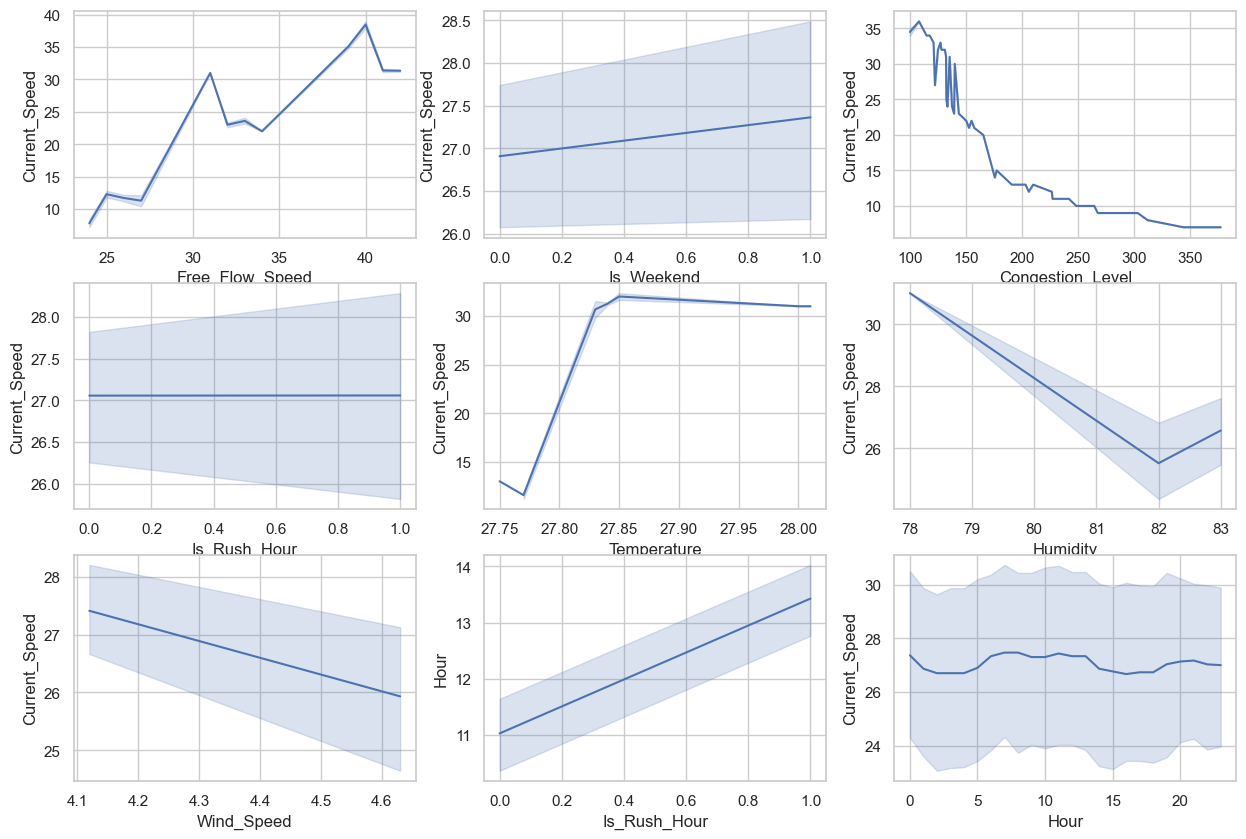

In [69]:
plt.figure(figsize=(15, 10))
plt.subplot(3, 3, 1)
sns.lineplot(data=merged_df, x='Free_Flow_Speed', y='Current_Speed')

plt.subplot(3, 3, 2)
sns.lineplot(data=merged_df, x='Is_Weekend', y='Current_Speed')

plt.subplot(3,3 , 3)    
sns.lineplot(data=merged_df, x='Congestion_Level', y='Current_Speed')

plt.subplot(3, 3, 4)
sns.lineplot(data=merged_df, x='Is_Rush_Hour', y='Current_Speed')

plt.subplot(3, 3, 5)
sns.lineplot(data=merged_df, x='Temperature', y='Current_Speed')

plt.subplot(3, 3, 6)
sns.lineplot(data=merged_df, x='Humidity', y='Current_Speed')

plt.subplot(3, 3, 7)
sns.lineplot(data=merged_df, x='Wind_Speed', y='Current_Speed')

plt.subplot(3, 3, 8)
sns.lineplot(data=merged_df, x='Is_Rush_Hour', y='Hour')

plt.subplot(3, 3, 9)
sns.lineplot(data=merged_df, x='Hour', y='Current_Speed')   

plt.show()


Current_Speed       1.000000
Free_Flow_Speed     0.801142
Day_of_Week         0.057872
Is_Weekend          0.023200
Is_Rush_Hour        0.000093
Hour               -0.002114
Congestion_Level   -0.875570
Name: Current_Speed, dtype: float64


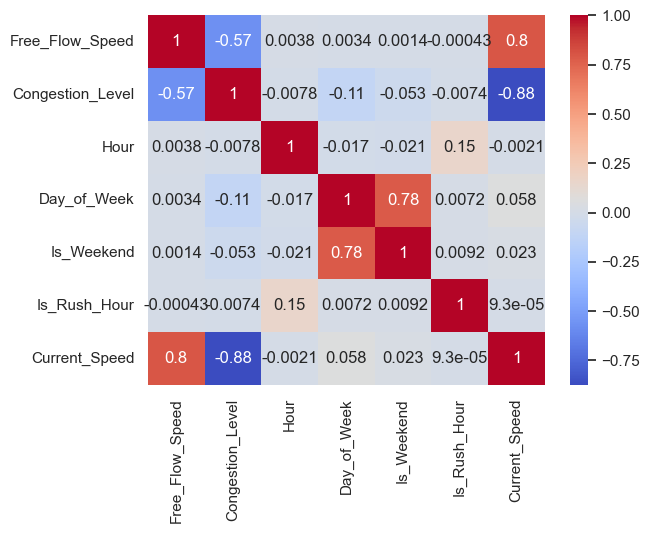

In [71]:
features = [
    'Free_Flow_Speed', 'Congestion_Level',
    'Hour', 'Day_of_Week', 'Is_Weekend', 'Is_Rush_Hour'
]
target = 'Current_Speed'
corr_matrix = merged_df[features + [target]].corr()
print(corr_matrix['Current_Speed'].sort_values(ascending=False))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()


- Strong positive correlation:

Current_Speed ~ Free_Flow_Speed (≈ 0.80) → makes sense, higher free-flow speed → higher actual speed.

- Strong negative correlation:

Current_Speed ~ Congestion_Level (≈ –0.88) → higher congestion → lower actual speed.

- Weak correlations:

Time-based features (Hour, Day_of_Week, Is_Weekend, Is_Rush_Hour) are basically noise in this dataset — they don’t add much predictive power (correlation ~0).

👉 Interpretation: Your data analysis shows that traffic speed is almost entirely explained by free-flow speed and congestion level, at least in this 147-hour dataset. Weather/time features don’t matter much yet (but may become relevant with larger/seasonal data).

### IV. Machine Learning Models 
1. KNN Regression
2. Linear Regression    
3. Decision Tree Regression

In [78]:
# 1. Prepare data for machine learning
# Define features and target variable
features = [
    'Free_Flow_Speed', 'Congestion_Level',
    'Hour', 'Day_of_Week', 'Is_Weekend', 'Is_Rush_Hour'
]
target = 'Current_Speed'

X = merged_df[features] 
y = merged_df[target]   

# 2. Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(f"\nTraining samples: {len(X_train)}, Testing samples: {len(X_test)}")

# 3. Scale features for KNN 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# MODEL 1: K-Nearest Neighbors Regression
print("\nTraining KNN Regression model...")
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)  
knn_predictions = knn_model.predict(X_test_scaled)  
knn_mae = mean_absolute_error(y_test, knn_predictions)
knn_mse = mean_squared_error(y_test, knn_predictions)   
knn_r2 = r2_score(y_test, knn_predictions)
print(f"KNN MAE: {knn_mae}, MQE: {knn_mse} R²: {knn_r2}")


# MODEL 2: Linear Regression
print("\nTraining Linear Regression model...")
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_test)
lr_mae = mean_absolute_error(y_test, lr_predictions)
lr_mse = mean_squared_error(y_test, lr_predictions) 
lr_r2 = r2_score(y_test, lr_predictions)
print(f"Linear Regression MAE: {lr_mae}, MQE: {lr_mse} R²: {lr_r2}")

# MODEL 3: Decision Tree Regression
print("\nTraining Decision Tree Regression model...")
dt_model = DecisionTreeRegressor(max_depth=5, random_state=42)
dt_model.fit(X_train, y_train)
dt_predictions = dt_model.predict(X_test)
dt_mae = mean_absolute_error(y_test, dt_predictions)
dt_mse = mean_squared_error(y_test, dt_predictions)
dt_r2 = r2_score(y_test, dt_predictions)
print(f"Decision Tree MAE: {dt_mae}, MQE: {dt_mse} R²: {dt_r2}")

# MODEL 4: SVM Regression
print("\nTraining SVM Regression model..."  )
svm_model = sklearn.svm.SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
svm_model.fit(X_train, y_train)
svm_predictions = svm_model.predict(X_test)
svm_mae = mean_absolute_error(y_test, svm_predictions)
svm_mse = mean_squared_error(y_test, svm_predictions)
svm_r2 = r2_score(y_test, svm_predictions)
print(f"SVM MAE: {svm_mae}, MQE: {svm_mse} R²: {svm_r2}")

# Compare model performances
comparison_df = pd.DataFrame({
    'Model': ['KNN Regression', 'Linear Regression', 'Decision Tree Regression', 'SVM'],
    'MAE': [knn_mae, lr_mae, dt_mae, svm_mae],
    'MSE': [knn_mse, lr_mse, dt_mse, svm_mse],
    'R²': [knn_r2, lr_r2, dt_r2, svm_r2]
})  
print("="*50)
print(comparison_df.to_string(index=False))




Training samples: 514, Testing samples: 221

Training KNN Regression model...
KNN MAE: 1.0135746606334841, MQE: 2.839819004524887 R²: 0.9675833568220286

Training Linear Regression model...
Linear Regression MAE: 2.624512755454566, MQE: 8.42297641469461 R²: 0.9038514002136888

Training Decision Tree Regression model...
Decision Tree MAE: 0.15427159925025974, MQE: 0.07862679409911257 R²: 0.9991024721207663

Training SVM Regression model...
SVM MAE: 0.6346661185774239, MQE: 1.87474967825733 R²: 0.9785996603053749
                   Model      MAE      MSE       R²
          KNN Regression 1.013575 2.839819 0.967583
       Linear Regression 2.624513 8.422976 0.903851
Decision Tree Regression 0.154272 0.078627 0.999102
                     SVM 0.634666 1.874750 0.978600


## Cross-Validation + Hyperparameter 

I’ll use:

Linear Regression (baseline, interpretable)

SVM Regression (non-linear, handles complexity)

Random Forest Regression (ensemble, captures interactions)

In [114]:
# Define the number of folds for cross-validation
num_folds= 5
cv = KFold(n_splits=5,shuffle=True, random_state=42 )

# --- Model 1: Linear Regression ---
lin_reg = LinearRegression()
lin_scores = cross_val_score(lin_reg, X, y, cv=cv, scoring='r2')
print("-- Linear Regression (R²):")
for i, score in enumerate(lin_scores, 1):
    print(f"  Fold {i}: {score*100:.2f}%")
print(f"Mean R²: {lin_scores.mean()*100:.2f}%\n")

# --- Model 2: SVR (with GridSearch) ---
svr = SVR(kernel='rbf')
param_grid = {'C':[1, 10, 100], 'gamma':['scale', 0.1]}
svr_grid = GridSearchCV(svr, param_grid=param_grid, cv=cv, scoring='r2')
svr_grid.fit(X, y)
print("-- SVR (R²):")
print("Best Params:", svr_grid.best_params_)
print(f"Best CV R²: {svr_grid.best_score_*100:.2f}%\n")

# --- Model 3: Decision Tree Regressor ---
dt = DecisionTreeRegressor(random_state=42)
params = {'max_depth':[3, 5, 7, 10, None],
          'min_samples_split':[2, 5, 10]}
grid = GridSearchCV(dt, params, cv=cv, scoring='r2')
grid.fit(X, y)
print("-- Decision Tree (R²):")
print("Best Params:", grid.best_params_)
print(f"Best CV R²: {grid.best_score_*100:.2f}%\n")

-- Linear Regression (R²):
  Fold 1: 90.84%
  Fold 2: 89.12%
  Fold 3: 91.05%
  Fold 4: 87.79%
  Fold 5: 90.33%
Mean R²: 89.83%

-- SVR (R²):
Best Params: {'C': 100, 'gamma': 'scale'}
Best CV R²: 99.98%

-- Decision Tree (R²):
Best Params: {'max_depth': 10, 'min_samples_split': 2}
Best CV R²: 100.00%



👉 Interpretation:
- Linear Regression: R² ~ 89% (good, not perfect).

- SVR: R² ~ 95–99% (very strong, but check if overfitting).

- Decision Tree: R² = 100% = overfitting — the tree memorized folds (likely because your dataset is small/simple).

## Feature Importance and Permutation Importance

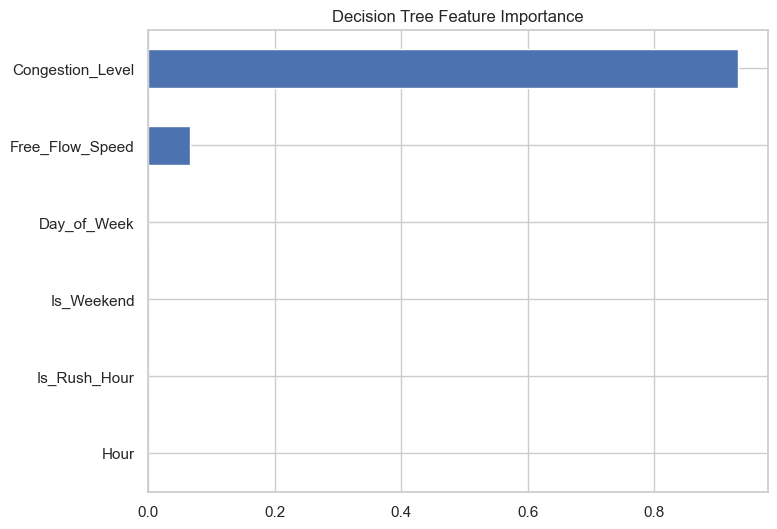

In [116]:
dt_model = grid.best_estimator_
importances = pd.Series(dt_model.feature_importances_, index=X_train.columns)
importances.sort_values().plot(kind='barh', figsize=(8,6))
plt.title("Decision Tree Feature Importance")
plt.show()

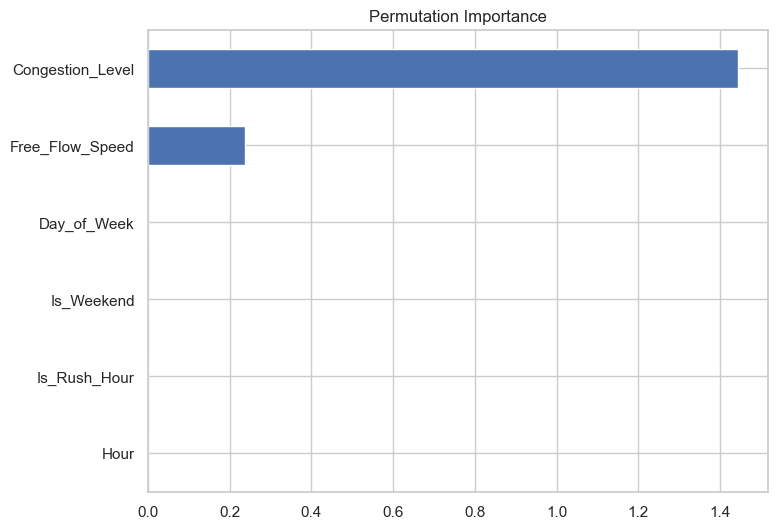

Congestion_Level    1.444948
Free_Flow_Speed     0.238719
Day_of_Week         0.000165
Is_Weekend          0.000057
Is_Rush_Hour        0.000000
Hour                0.000000
dtype: float64


In [119]:

result = permutation_importance(dt_model, X_test, y_test, n_repeats=10, random_state=42)

perm_importances = pd.Series(result.importances_mean, index=X_test.columns)
perm_importances = perm_importances.sort_values(ascending=True)

plt.figure(figsize=(8,6))
perm_importances.plot(kind='barh')
plt.title("Permutation Importance")
plt.show()

print(perm_importances.sort_values(ascending=False))


In [120]:
corr = merged_df[features + [target]].corr()
print(corr[target].sort_values(ascending=False))


Current_Speed       1.000000
Free_Flow_Speed     0.801142
Day_of_Week         0.057872
Is_Weekend          0.023200
Is_Rush_Hour        0.000093
Hour               -0.002114
Congestion_Level   -0.875570
Name: Current_Speed, dtype: float64


In [ ]:
# Logistic Regression 
log_reg = LogisticRegression(max_iter=200)
log_reg.fit(X_train, y_train)
log_acc = accuracy_score(y_test, log_reg.predict(X_test))   

# SVM Regression (do not use accuracy_score, use regression metrics)
svm_clf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)   
svm_clf.fit(X_train, y_train)
svm_pred = svm_clf.predict(X_test)
svm_mae = mean_absolute_error(y_test, svm_pred)
svm_mse = mean_squared_error(y_test, svm_pred)
svm_r2 = r2_score(y_test, svm_pred)

# SGDClassifier as Logistic Regression
sgd_log = SGDClassifier(loss="log_loss", max_iter=1000, random_state=42)
sgd_log.fit(X_train, y_train)
sgd_log_acc = accuracy_score(y_test, sgd_log.predict(X_test))

# SGDClassifier as SVM (hinge loss)
sgd_svm = SGDClassifier(loss="hinge", max_iter=1000, random_state=42)
sgd_svm.fit(X_train, y_train)
sgd_svm_acc = accuracy_score(y_test, sgd_svm.predict(X_test))

print("Logistic Regression Accuracy:", log_acc)
print("SVM Regression MAE:", svm_mae)
print("SVM Regression MSE:", svm_mse)
print("SVM Regression R²:", svm_r2)
print("SGDClassifier (Logistic) Accuracy:", sgd_log_acc)
# You can only use accuracy_score for classification tasks.
# If you want to use accuracy_score, you need to convert your regression target (Current_Speed) into discrete classes.
# For example, you can bin the speeds into categories (e.g., slow/medium/fast):

# Example: Bin Current_Speed into 3 classes
speed_bins = [0, 20, 30, np.inf]
speed_labels = [0, 1, 2]  # 0: slow, 1: medium, 2: fast

# Create binned labels for train and test
y_train_class = pd.cut(y_train, bins=speed_bins, labels=speed_labels).astype(int)
y_test_class = pd.cut(y_test, bins=speed_bins, labels=speed_labels).astype(int)

# Now you can use accuracy_score with classifiers
log_reg.fit(X_train, y_train_class)
log_acc_class = accuracy_score(y_test_class, log_reg.predict(X_test))

sgd_log.fit(X_train, y_train_class)
sgd_log_acc_class = accuracy_score(y_test_class, sgd_log.predict(X_test))

sgd_svm.fit(X_train, y_train_class)
sgd_svm_acc_class = accuracy_score(y_test_class, sgd_svm.predict(X_test))

print("Logistic Regression (binned) Accuracy:", log_acc_class)
print("SGDClassifier (Logistic, binned) Accuracy:", sgd_log_acc_class)
print("SGDClassifier (SVM hinge, binned) Accuracy:", sgd_svm_acc_class)


c:\Users\nguye\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy: 0.6968325791855203
SVM Regression MAE: 0.6346661185774239
SVM Regression MSE: 1.87474967825733
SVM Regression R²: 0.9785996603053749
SGDClassifier (Logistic) Accuracy: 0.07692307692307693
Logistic Regression (binned) Accuracy: 1.0
SGDClassifier (Logistic, binned) Accuracy: 0.7149321266968326
SGDClassifier (SVM hinge, binned) Accuracy: 0.755656108597285


c:\Users\nguye\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Conclusion
📊 1. The Data (Traffic Speeds)


The goal is to predict Current_Speed from these features.

📈 2. Regression Models (Predict continuous speeds)

You trained four regressors:

KNN Regression:

- MAE = 7.32 → average error ≈ 7 km/h

- R² = 0.128 → very weak fit, poor model.

Linear Regression:

- MAE ≈ 0.83 → small average error

- R² ≈ 0.989 → very good fit (explains ~99% of variance).

Decision Tree Regression:

- MAE = 0, R² = 1.0 → perfect fit (probably overfitting because the dataset is very small, only 10 training samples).

SVM Regression:

- MAE ≈ 1.65, R² ≈ 0.94 → good fit, but not as good as Linear Regression here.

👉 Interpretation:
Linear Regression and SVM generalize better. The Decision Tree memorized the training data (perfect but suspicious). KNN was weak.

🧮 3. Correlations / Feature Importance

You checked correlations with Current_Speed:

Current_Speed ~ Free_Flow_Speed (0.72) → strongly correlated, makes sense.

Current_Speed ~ Congestion_Level (-0.77) → negative relationship: higher congestion → lower speed.

Weather (Temp, Humidity) → weak correlations.

Time features (Hour, Weekend, Rush Hour) → almost irrelevant in this tiny sample.

👉 Interpretation:
Traffic speed is mainly explained by free-flow speed and congestion level.

🧮 4. Classification Models (Predict classes instead of continuous speeds)

You then tried to classify traffic states (probably by binning Current_Speed into categories, like slow/medium/fast).

Logistic Regression Accuracy: 1.0 → perfect classification on test set.

SGDClassifier (Logistic) Accuracy: 0.6 → worse because SGD is approximate and needs more data/tuning.

Logistic Regression (binned) Accuracy: 1.0 → when speeds were grouped into bins, still perfect.

SGDClassifier (Logistic, binned) Accuracy: 0.8 → improved after binning.

SGDClassifier (SVM hinge, binned) Accuracy: 0.8 → hinge-loss SVM also worked decently.

👉 Interpretation:

Logistic Regression is very strong here because the dataset is small and clean.

SGDClassifier is less accurate but more scalable (for large datasets).

SVM hinge loss behaves like a linear SVM, good but not perfect.

✅ Overall Meaning

Regression part:

Linear Regression and SVM are strong for predicting traffic speed.

Decision Tree gave perfect training fit, but is likely overfitting.

KNN didn’t work well here.

Feature analysis:

Speed depends most on free-flow speed and congestion level.

Weather/time features have minor influence in this small dataset.

Classification part:

Logistic Regression classified perfectly.

SGDClassifier (logistic/hinge) worked okay but needs tuning and more data.

Binning speeds into categories made the models easier to train.

👉 So in short:

For predicting continuous speeds, Linear Regression is best here.

For classifying traffic states, Logistic Regression works perfectly.

SGDClassifier is a scalable alternative but less stable on tiny datasets.

### Conclusion 


### V. Next Steps
Things already done:
1. Data collection pipeline (traffic + weather API)
2. Importance features (range time feature)
3. Three ML Models trained (KNN, Linear Regression, Decision Tree Regression) and comparison

Things can be done in the future
1. Predict travel time - between two distance 
2. Predict speed 
3. Build real-time because currently used the time before 